# PrivECG: Anonymizing ECG Data for Privacy-Preserving Cardiovascular Diagnosis

## Github Link: [https://github.com/DHUIUC/PrivECG](https://github.com/DHUIUC/PrivECG)

## Video Link:

https://uillinoisedu-my.sharepoint.com/:v:/g/personal/dth3_illinois_edu/EcVX9sOkNStKvTeWk3O8AS4BBZ79cAERHgMqNZE-2bxSKA?nav=eyJyZWZlcnJhbEluZm8iOnsicmVmZXJyYWxBcHAiOiJPbmVEcml2ZUZvckJ1c2luZXNzIiwicmVmZXJyYWxBcHBQbGF0Zm9ybSI6IldlYiIsInJlZmVycmFsTW9kZSI6InZpZXciLCJyZWZlcnJhbFZpZXciOiJNeUZpbGVzTGlua0NvcHkifX0&e=8LZDzZ


## Authors
- Original Authors: Alexis Nolin-Lapalme, Robert Avram, Hussin Julie
- Contributor: Dillon Harding (Improvements, Ablations)

# Introduction:
## Background
In the original paper, PrivECG aims to address the potential privacy risks associated with using electrocardiogram (ECG) data for diagnosing cardiovascular disease. ECG data is invaluable in its ability be utilized in training machine learning models, though there is the potential of the data to reveal private attributes such as age and sex. With state of the art models, even patient re-identification is possible. A potential solution to this issue is PrivECG, which aids in anonymizing the ECG data while retaining the diagnostic utility of the data. 

The approach used in PrivECG involves a Generative Adversarial Network (GAN) to anonymize patient data. The model aims to reduce the accuracy of predicting a patient's sex while preserving other features of the data relevant to disease diagnosis. The GAN uses a generator and discriminator to achieve this result. The discriminator attempts to determine the sex of a patient based on the ECG data, whereas the generator learns to remove features of the data that would otherwise assist in the determining of a patient's sex. This ideally makes the accuracy effectively random (~50%).

The original paper cites a variant of PrivECG, "PrivECG-lambda", limited the sex prediction accuracy to 0.529 +- 0.014, while retaining its ability to determine diagnosis on the transformed data. The diagnosis classification for "PrivECG-lambda" had very high performance with an AUPR of 0.96 +- 0.006 despite limiting the ability of predicting the patient's sex. This paper is incredibly meaningful for data privacy in machine learning models, as models can utilize privECG to eliminate predictibility of identifiable traits while retaining viability of their target prediction variable. y.


# Scope of Reproducibility:

In recreating this project, I will be attempting to test two hypotheses. The paper claims that it can “anonymize a large ECG database in minutes”, which leads me to believe that this paper can be recreated with any ECG dataset. 

- Hypothesis 1: I will be testing if it is possible to glean similar results from the paper using alternate ECG datasets than the original used in the paper.
- Hypothesis 2: This hypothesis comes from the authors’ GitHub, in which they state a future improvement could be to “try to induce privacy by simply varying rhythm, thus requiring less transformation and allowing better readability”. (Obviusly dependent on the success of the 1st hypothesis)

I would like to see if I can make these improvements upon their codebase, and aim to do so by modifying the GAN to discriminate and generate heartbeat rhythm in conjunction with or in place of sex-defining features. I find that Transfer Learning could be beneficial in this attempt. 

Given the low complexity of the model as well as the manageable size of data, I believe replication of PrivECG should be possible on my personal hardware. Additionally, an aim of the project is to be efficient on large databases, which leads me to believe it could likely be done on lesser hardware. 

# Methodology

Below is the associated methodology in which I attempt to recreate the privECG model. One main struggle discovered in the attempt to reproduce PrivECG is installing all necessary dependencies. The packages are very dependency specific, so it is difficult to install all packages and import them with their Python version dependencies. 

Beyond that, a notable issue I ran into was with the CUDA version associated with the torch package specified in the original paper's requirements.txt file. The same issues occurred for the keras/tensorflow versioning. It was determined that some functions of how the original code were structured makes it impossible to be run with newer versions of keras without heavy modification, primarily due to the BatchNormalization method in keras/layers.

Another dependency that is not covered in the requirements.txt is ecgdetectors, a python package in utils.py

# Environment

In the git repository associated with this attempted recreation of PrivECG, I have included an updated requirements.txt file. This file merely depicts the python packages and their associated approximate version numbers. In addition to these Python packages, you will need a Python version that supports the required packages. I found that Python version 3.11.7 was stable for running this code. A final component which I would almost certainly call a requirement is CUDA. This model heavily leverages CUDA with pytorch for its training. For anyone looking to train this model who has access to an NVIDIA GPU, use CUDA to increase training time drastically. Below is a list of all packages and their version numbers used in this project:

- python (3.11.7)
- numpy==1.26.4
- pandas==2.1.4
- torch==2.2.2
- tqdm==4.65.0
- scikit-learn==1.3.0
- py-ecg-detectors
- scipy==1.11.4
- similaritymeasures==0.7.0
- frechetdist
- adapt
- keras==2.11.0
- tensorflow==2.12.0
- keras_resnet
- focal-loss==0.0.7
- CUDA (11.8)


All of these required packages can be installed in an anaconda python environment, in which multiple were used for this project. Due to dependencies in some packages I elected to use a separate environment for training and evaluation of the model. It is likely possible to utilize a single anaconda python environment, but a dependency I ran into came from the adapt package, used in tandem the frechetdist package. 

For those interested in training the model on an NVIDIA GPU with CUDA, use the following within an anaconda shell to install pytorch with CUDA:

`conda install pytorch==2.2.2 torchvision==0.17.2 torchaudio==2.2.2 pytorch-cuda=11.8 -c pytorch -c nvidia`

This comes from the official pytorch documentation at: [https://pytorch.org/get-started/previous-versions/](https://pytorch.org/get-started/previous-versions/) 

In [1]:
## IMPORTS ##

## GENERAL & TRAINING ##
import os
import numpy as np
import random 
import pandas as pd
from statistics import mean
import torch
from torch.utils.data import Dataset, DataLoader 
from tqdm import tqdm
import gc
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data
import math
from sklearn.model_selection import train_test_split
from utils import *
from models import *


## EVALUATION ##
import keras
import tensorflow as tf
import keras_resnet.models
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import Model
from keras.layers import Lambda
from tensorflow.keras.layers import Flatten
from resnet1d import *
from tensorflow.python.keras import backend as K

# Data

The main hypothesis lies in the ability to replicate PrivECG on separate data. I managed to find 12-lead ECG data that was made public in a separate paper (see reference 3 in references section). Unfortunately, due to the size of the data, being GBs in size for each folder, it is not possible to include within the git repository, even in a compressed format. As such, for those who wish to access the data, please see the link in reference 3 and download the zip files attached to the bottom of the paper.

The data primarily consists of folders of excel files that are linked to ECG readings in a patient, whose anonymous ID is the title of the excel file. The data is of size (5000, 12) per patient, which represents a 12-lead ECG read over a period of 10 seconds at a rate of 500 readings a second. In addition to the ECG data is an index file which maps an anonymous patient ID to many predicting factors, one of which being their biological sex.

There are quite a few data pre-processing steps that were needed to be performed before using the data in the GAN model below. The data originally came in shape (N, 5000, 12) which is typical for an ECG, but the data exists as separate excel files, where the model expects downsampled numpy arrays of size (N, 500, 12). Thus, it was imperative to read the data (which was incredibly memory intensive) from the Excel files to numpy arrays. Beyond this, I needed to generate R-Waves and non-R-Waves, as this is key to anonymizing the data. This process relies on finding the peaks in the ECG per lead. 

After generating the R-wave and non-R-wave data, I then downsampled the ECG data, R-wave, and non-R-wave data to be of size (N, 500, 12) to conform to the expected dimensions of privECG. 

I sorted the file Diagnostics.xlsx by filename and retrieved the Gender column to use as my sex vector for predictors in the GAN. All of this python code exists with the repository as: createMasks.py, downsample.py, readFromExcel.py, readDiagnostics.py. The Excel data can be found in the folder /data/ in the repository. 

For those who wish to recreate the data, they may simply run the aforementioned python scripts. Otherwise, the stored numpy arrays are loaded below.


In [37]:
## FILE AND DATA READING ##

#FILEPATHS
data_path = 'to_model/ecg_data.npy'
r_mask_path = 'to_model/r_wave_masks.npy'
nr_mask_path = 'to_model/non_r_wave_masks.npy'
sex_labels_path = 'to_model/gender_data.npy'
out_path = 'output_folder'

#FORMERLY ARGUMENTS, NOW CONSTANTS
cuda_device = 'cuda:0'
learning_rate = 1e-7
batch_size_ = 64
beta_1 = 0.5
beta_2 = 0.990
loss_type = 'MSE'
multiplicator = 100
mode = 'PrivECG'
save_every = 3
number_epochs = 500 #RAISE OR LOWER AS NEEDED
utility_budget = 0.0001
experiment_id = 'exp_1'

#READ FROM FILES, ESTABLISH VARS
device = cuda_device 
ecg_data = np.load(data_path)
R_mask = np.load(r_mask_path)
non_R_mask = np.load(nr_mask_path)
y_ = np.load(sex_labels_path, allow_pickle=True)
y_ = np.array([0 if i == 'MALE' else 1 for i in y_])

# Using PrivECG
generator = GeneratorUNet().to(device)
disciminator = Discriminator().to(device)

#Normalization from PrivECG paper
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def normalize_all(data):
    for row in tqdm(range(data.shape[0])):
        for col in range(data.shape[1]):
            data[row][col] = np.squeeze(NormalizeData(data[row][col])).astype('float32')
    return data

train_X = normalize_all(np.copy(ecg_data))

#Moved this section out of the model code so that it can be used in evaluation of pre-trained model
d_train = DatasetTrain(train_X,y_,R_mask,non_R_mask)

distortion_loss = nn.MSELoss()
adversarial_loss = nn.BCEWithLogitsLoss()
adversarial_loss_rf = nn.BCEWithLogitsLoss()

train_loader = DataLoader(dataset=d_train, batch_size=int(batch_size_), shuffle=True)

100%|████████████████████████████████████████████████████████████████████████████| 10646/10646 [02:24<00:00, 73.48it/s]


## Data Visualization

Below are visualizations of a random sample within the ECG dataset. The plots represent a visualization of the ECG data, as well as measurements for the distribution of males and females in the dataset

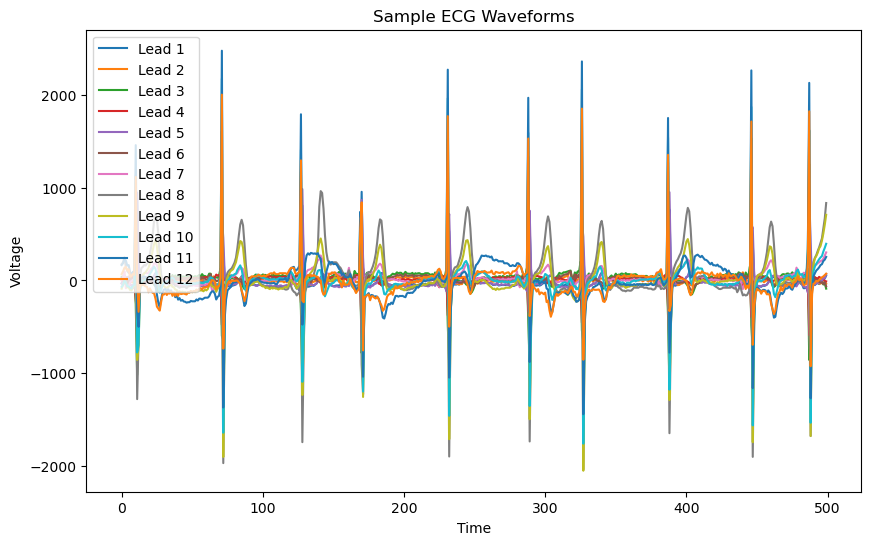

Count of Male: 5956
Count of Female 4690


In [42]:
import matplotlib.pyplot as plt

#Feel free to re-run this ceel to get a new ECG reading
random_index = np.random.randint(ecg_data.shape[0])

#RANDOM ECG DATA SAMPLE
plt.figure(figsize=(10, 6))

for lead_index in range(ecg_data.shape[2]):
    plt.plot(ecg_data[random_index, :, lead_index], label=f'Lead {lead_index+1}')

plt.title('Sample ECG Waveforms')
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.legend()
plt.show()

#Gender distribution
print("Count of Male:", np.count_nonzero(y_ == 0))
print("Count of Female", np.count_nonzero(y_ == 1))

# Model

The model below is a GAN that stays as close as possible in line with the original code from the PrivECG repository. The repository can be found at the following link (reference 2 in reference section): [https://github.com/anolinlapalme/privECG](https://github.com/anolinlapalme/privECG)

The original paper which describes the PrivECG model can be found at:

> Nolin-Lapalme, A., Avram, R. & Julie, H. (2023). PrivECG: generating private ECG for end-to-end anonymization. Proceedings of the 8th Machine Learning for Healthcare Conference, in Proceedings of Machine Learning Research 219:509-528 Available from https://proceedings.mlr.press/v219/nolin-lapalme23a.html

Significant modifications contain comments, but largely the code is true to form. Specifically speaking, the model itself is untouched, and is within the helper python script models.py. I have included the code below as markup, as the code is already imported and executed from within the same directory. 

As a GAN, the model contains a Generator and Discriminator which work to generate and distinguish newly created data from input data. The particular aim of this model is to use the generator to create new downsampled ECG data based on input ECG data. The newly generated data will ideally have lower accuracies in determining sex of a patient. This will be determined by the Discriminator, which aims to determine the sex of the samples' ECG data using the original labels from the real data. 

The Generator is a U-Net model which includes multiple layers for feature extraction and expansion, with dropout regularization and normalization techniques. The model finishes with a final output layer with upsampling and convolutional operations followed by a sigmoid activation function.

The Discriminator consists of convolutional blocks with leaky ReLU activation functions for downsampling and feature extraction. It includes fully connected layers with dropout regularization for classification, with a single output node for binary classification.

In [ ]:
import torch
from torch.nn.functional import relu, max_pool1d, sigmoid, log_softmax
import torch.nn as nn

device='cuda:0'
#device = 'cpu'
#----------------#
#   Generator    #
#----------------#

class UNetDownPath(nn.Module):
    def __init__(self, in_size, out_size, ksize=4, stride=2, normalize=True, dropout=0.0):
        super(UNetDownPath, self).__init__()
        layers = [nn.Conv1d(in_size, out_size, kernel_size=ksize,
                            stride=stride, bias=False, padding_mode='replicate')]
        if normalize:
            layers.append(nn.InstanceNorm1d(out_size))
        layers.append(nn.ReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UNetUpPath(nn.Module):
    def __init__(self, in_size, out_size, ksize=4, stride=2, output_padding=0, dropout=0.0):
        super(UNetUpPath, self).__init__()
        layers = [
            nn.ConvTranspose1d(in_size, out_size, kernel_size=ksize,
                               stride=stride, output_padding=output_padding, bias=False),
            nn.InstanceNorm1d(out_size),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)

        self.pad = nn.ConstantPad1d((1,0,0,0),0)

    def forward(self, x, skip_input):
        x = self.model(x)

        if skip_input.shape[-1] == 310 or skip_input.shape[-1] == 623 or skip_input.shape[-1] == 1249:
            skip_input = self.pad(skip_input)

        x = torch.cat((x, skip_input), 1)

        return x

class Interpolate(nn.Module):
    def __init__(self, size):
        super(Interpolate, self).__init__()
        self.interp = nn.functional.interpolate
        self.size = size
        
    def forward(self, x):
        x = self.interp(x, size=self.size,mode='linear')
        return x

class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=12, out_channels=12):
        super(GeneratorUNet, self).__init__()

        self.down1 = UNetDownPath(in_channels, 128, normalize=False)
        self.down2 = UNetDownPath(128, 256,dropout=0.5)
        self.down3 = UNetDownPath(256, 512, dropout=0.5)
        self.down4 = UNetDownPath(512, 512, dropout=0.5, normalize=False)

        self.up1 = UNetUpPath(512, 512, output_padding=0, dropout=0.5)
        self.up2 = UNetUpPath(1024, 256, output_padding=1,dropout=0.5)
        self.up3 = UNetUpPath(512, 128, output_padding=1,dropout=0.5)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ConstantPad1d((1, 1), 0),
            nn.Conv1d(256, out_channels, 4, padding=2,
                      padding_mode='replicate'),
            Interpolate(size=[500]),
            nn.Sigmoid(),
        )
        self.project_noise = nn.Linear(512, 512)
    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        
        d4 = d4 + (0.1)*torch.randn(d4.shape).to(device)

        u1 = self.up1(d4, d3)
        u2 = self.up2(u1, d2)
        u3 = self.up3(u2, d1)
        u4 = self.final(u3)

        return u4

#-----------------#
#  Discriminator  #
#-----------------#

class Discriminator(nn.Module):
    def __init__(self, in_channels=12):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, ksize=6, stride=3, normalization=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv1d(in_filters, out_filters, ksize,
                                stride=stride, padding_mode='replicate')]
            if normalization:
                layers.append(nn.InstanceNorm1d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels, 128, normalization=False),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),nn.Conv1d(512, 64, 4, bias=False, padding_mode='replicate'))

        self.flatten_1 = nn.Linear(in_features=896,out_features=448)
        self.relu_f1 = nn.ReLU(inplace=True)

        self.flatten_2 = nn.Linear(in_features=448,out_features=224)
        self.relu_f2 = nn.ReLU(inplace=True)

        self.flatten_3 = nn.Linear(in_features=224,out_features=1)
        self.relu_f3 = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(0.4)  #2.0
        
    def forward(self, data):
        x = self.model(data)
        x = torch.flatten(x,1)
        x = self.relu_f1(self.flatten_1(x))
        x = self.dropout(x)
        x = self.relu_f2(self.flatten_2(x))
        x = self.dropout(x)
        x = self.flatten_3(x)
        x = torch.squeeze(x)
        return x

# Training

The model is trained over 500 epochs, with 167 iterations for each epoch. This is rather computationally heavy, so it is heavily advised to use pytorch paired with CUDA. The code used for training is included below. For those who wish to train the model themselves, feel free to run the code. However, there is already a pretrained model saved which can be loaded in subsequent Analysis cells. 

## Hyperparameters

In training this GAN model, I aimed to follow the guidelines set by the original PrivECG paper. The original paper uses a batch size of 64 for training, with a learning rate of 1e-7. Additionally, two hyperparameters, beta_1 set to 0.5 and beta_2 set to 0.99, are used in the optimizer for the model. It is not explicitly stated in the paper how the authors arrived at these parameters, but in my attempt to recreate their accomplishments, I aimed to follow their guidelines.

## Computational Requirements

With this training being rather computationally demanding, it is recommended to train this model using a higher specification GPU, with some other high performance components as well. While it is uncertain the exact limitations for minimum hardware requirements, I was able to train this model with the following hardware specifications:

- CPU (AMD Ryzen 5, 6 Core) - 3.6 GHz
- RAM - 16 GB
- GPU (NVIDIA 1660) - 6GB VRAM
- cooling system (liquid cooling, adequate number of fans)

With the above hardware, I was able to train the model at roughly 1 epoch each every 15 seconds. This over all took a time of roughly 2 hours. I elected to stop the training early if there was no noticeable sign of progress in ~100 iterations. 

The following training code was rather difficult to run without error. Initially, I ran into CUDA erors, which only allowed CPU training. This attempt was estimated to take 25+ hours, to which I elected to spend more time troubleshooting and properly installing CUDA on my system. Another major discrepancy was the specified shape of the input data compared to what was expected by the GAN model. An added transposition was necessary in order for the GAN to accept the ECG data. Over all, there were likely over 2 dozen training attempts made before successful training attempts went through. 

In [ ]:
## FROM run_models.py FROM ORIGINAL PrivECG GitHub ##


## !!!  IMPORTANT  !!!! ##
## !!!! YOU NEED NOT RUN THIS CELL IF YOU DO NOT WISH TO TRAIN THE MODEL !!! ##

optimiser_gen = torch.optim.Adam(generator.parameters(), lr=learning_rate ,betas = (beta_1, beta_2)) 
optimiser_discr = torch.optim.Adam(disciminator.parameters(), lr=learning_rate, betas = (beta_1, beta_2)) 
num_epochs = number_epochs

list_fake_acc = list()
list_true_acc = list()
list_generator_loss = list()
list_distortion_loss = list()
list_gender_loss = list()
list_genderless_loss = list()
list_true_data_loss = list()
list_dicriminator_loss = list()

os.makedirs(out_path, exist_ok=True)

for epochs in range(0,num_epochs):
    print('Epoch: {}'.format(epochs))
    G_distortion_loss_accum = 0
    G_adversary_loss_accum = 0
    D_real_loss_accum = 0
    D_fake_loss_accum = 0

    generator.train()
    disciminator.train()
    
    acc_true_acc = list()
    acc_fake_acc = list()
    acc_generator_loss = list()
    acc_distortion_loss = list()
    acc_gender_loss = list()
    acc_genderless_loss = list()
    acc_true_data_loss = list()
    acc_dicriminator_loss = list()

    #GPU RELATED VARS
    LongTensor = torch.cuda.LongTensor
    FloatTensor = torch.cuda.FloatTensor

    for i, (x, gender, r_masked, non_r_masked) in enumerate(tqdm(train_loader)):
        gender = gender.type(torch.float32)

        #CPU RELATED VARS
        #x = x.type(torch.float32)
        #non_r_masked = non_r_masked.type(torch.float32)
        #r_masked = r_masked.type(torch.float32)

         #GPU RELATED VARS
        gender =  gender.to(device=device)
        x = x.to(device=device, dtype=torch.float32)
        non_r_masked =  non_r_masked.to(device,dtype=torch.float32)
        r_masked =  r_masked.to(device,dtype=torch.float32)

        optimiser_gen.zero_grad()

        #generate the random gender vector

        #CPU line
        #gen_secret = Variable(torch.LongTensor(np.random.choice([1.0], x.shape[0])))#.to(device)

        #GPU line
        gen_secret = Variable(LongTensor(np.random.choice([1.0], x.shape[0]))).to(device)
        
        gen_secret = gen_secret * np.random.normal(0.5, math.sqrt(0.01))

        gen_secret = gen_secret.type(torch.float32)
        gen_secret =  gen_secret.to(device=device) #FOR GPU

        # ----------- Generator --------------

        x = torch.transpose(x, 1, 2) #Necessary to make model accept data?
        
        #get outputs of the networks
        gen_results = generator(x)
        print

        pred_secret = disciminator(gen_results)

        # 'MSE','MSE_R'
        if loss_type == 'MSE':
            #CPU
            #generator_distortion_loss = distortion_loss(gen_results, x)#.to(device)
            #GPU
            generator_distortion_loss = distortion_loss(gen_results, x).to(device)

        elif loss_type == 'MSE_R':
            generator_distortion_loss = distortion_loss(gen_results * r_masked, x * r_masked) + distortion_loss(gen_results * non_r_masked, x * non_r_masked)* multiplicator

        
        G_distortion_loss_accum += generator_distortion_loss.item()

        #DEFAULT TO PrivECG, not GenGan
        generator_adversary_loss = adversarial_loss(pred_secret, gen_secret).to(device) #COMMENT OUT .to(device) for CPU

        G_adversary_loss_accum += generator_adversary_loss.item()

        generator_loss = generator_distortion_loss + generator_adversary_loss * utility_budget

        acc_distortion_loss.append(generator_distortion_loss.item())
        acc_gender_loss.append(generator_adversary_loss.item())
        acc_generator_loss.append(generator_loss.item())

        generator_loss.backward()
        optimiser_gen.step()

        # ----------- Discriminator --------------
    
        optimiser_discr.zero_grad()

        real_pred_secret = disciminator(x)
        fake_pred_secret = pred_secret.detach()

        acc_true_acc.append(np.mean(torch.sigmoid(real_pred_secret).reshape(-1).clone().detach().cpu().numpy().round() == gender.detach().cpu().numpy()))
        acc_fake_acc.append(np.mean(torch.sigmoid(pred_secret).reshape(-1).clone().detach().cpu().numpy().round() == gender.detach().cpu().numpy()))

        #CPU
        #D_real_loss = adversarial_loss_rf(real_pred_secret, gender)#.to(device)
        #D_genderless_loss = adversarial_loss_rf(fake_pred_secret, gen_secret)#.to(device)

        #GPU
        D_real_loss = adversarial_loss_rf(real_pred_secret, gender).to(device)
        D_genderless_loss = adversarial_loss_rf(fake_pred_secret, gen_secret).to(device)
        
        D_real_loss_accum += D_real_loss.item()
        D_fake_loss_accum += D_genderless_loss.item()

        discriminator_loss = D_real_loss + D_genderless_loss 

        acc_genderless_loss.append(D_genderless_loss.item())
        acc_true_data_loss.append(D_real_loss.item())
        acc_dicriminator_loss.append(discriminator_loss.item())

        discriminator_loss.backward()
        optimiser_discr.step()
    
    list_fake_acc.append(mean(acc_fake_acc))
    list_true_acc.append(mean(acc_true_acc))
    list_generator_loss.append(mean(acc_generator_loss))
    list_distortion_loss.append(mean(acc_distortion_loss))
    list_gender_loss.append(mean(acc_gender_loss))
    list_genderless_loss.append(mean(acc_genderless_loss))
    list_true_data_loss.append(mean(acc_true_data_loss))
    list_dicriminator_loss.append(mean(acc_dicriminator_loss))

    print("==============================")
    print("epoch {}".format(epochs))

    print("list_fake_acc {}".format(mean(acc_fake_acc)))
    print("list_true_acc {}".format(mean(acc_true_acc)))
    print("diff acc {}".format(mean(acc_true_acc) - mean(acc_fake_acc)))

    print("list_generator_loss {}".format(mean(acc_generator_loss)))
    print("list_distortion_loss {}".format(mean(acc_distortion_loss)))
    print("list_gender_loss {}".format(mean(acc_gender_loss)))
    #print("list_genderless_loss {}".format(mean(acc_genderless_loss)))
    #print("list_true_data_loss {}".format(mean(acc_true_data_loss)))
    #print("list_dicriminator_loss {}".format(mean(acc_dicriminator_loss)))
    print("==============================")

    if epochs%save_every == 0:
        torch.save(disciminator.state_dict(), os.path.join(out_path,'disciminator_{}_final.pth'.format(epochs)))
        torch.save(generator.state_dict(), os.path.join(out_path,'generator_{}_final.pth'.format(epochs)))


# Evaluation

The code below was used to value the saved model which resulted from the training process. Using the saved model, new data is generated and saved. This new generated data is then used in conjunction with the original data and original labels in order to determine the test loss and test accuracy. 

While this code was subject to versioning errors from keras and tensorflow and needed to be executed in a separate environment, the output of the code will be in raw form at the end of this section. Running the code with the keras version specified in the requirements will provide very similar results.

Another form of evaluating the model comes during the training process, as after each epoch a summary of the training metrics is produced to display the iterative success of the model's learning. This will be referenced in the **Results** section. 

In [11]:
#Receive generated data from trained model

generator_path = 'output_folder/generator_150_final.pth'

generator.load_state_dict(torch.load(generator_path))

generator.eval()

generated_data = []
batch_size = 64

#generate data
with torch.no_grad():
    for i, (x, gender, r_masked, non_r_masked) in enumerate(tqdm(train_loader)):

        x = x.to(device=device, dtype=torch.float32)
        x = torch.transpose(x, 1, 2) #Necessary to make model accept data?
                
        batch_generated_data = generator(x)  #generate batch of data
        generated_data.append(batch_generated_data)

#concatenate batches to get final generated data
generated_data = torch.cat(generated_data, dim=0)

#convert to numpy data to match original
generated_data_np = generated_data.cpu().numpy().reshape(-1, 500, 12)

#save the numpy array
np.save('generated/generated_data.npy', generated_data_np)
print(generated_data_np.shape)


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:04<00:00, 38.19it/s]


(10646, 500, 12)


In [5]:
def create_model(input_shape, top='flatten'):

    BottleneckLayer = {
        'flatten': Flatten()
    }[top]

    input_1 = keras.layers.Input(input_shape)
    input_2 = keras.layers.Input(input_shape)

    #this line will result in an error deeply nested within the keras package, which details that input_shape
    #is not defined for a BatchNormalization operation
    base = ResNet1D50(keras.layers.Input(input_shape),include_top=False)
    x_1 = BottleneckLayer(input_1)
    x_2 = BottleneckLayer(input_2)

    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([x_1, x_2])

    outputs = Dense(1, activation="sigmoid")(L1_distance)
    
    model = Model(inputs=[input_1, input_2], outputs=outputs)
    return model

In [ ]:
orig_data_path = 'to_model/ecg_data.npy'
generated_data_path = 'generated/generated_data.npy'
label_data_path = 'to_model/gender_data.npy'
output_dir = 'evaluation'

#X
orig_data_np = np.load(orig_data_path)
generated_data_np = np.load(generated_data_path)

#Y
label_data_np = np.load(label_data_path, allow_pickle=True)
label_data_np = np.array([0 if i == 'MALE' else 1 for i in label_data_np])

#split original data on a 0.6/0.2/0.2 ratio for train/test/val
orig_train_val, x_test_1 = train_test_split(orig_data_np, test_size=0.2, random_state=42)
x_train_1, x_val_1 = train_test_split(orig_train_val, test_size=0.25, random_state=42)  #0.25 * 0.8 = 0.2

#split generated data on a 0.6/0.2/0.2 ratio for train/test/val
gen_train_val, x_test_2 = train_test_split(generated_data_np, test_size=0.2, random_state=42)
x_train_2, x_val_2 = train_test_split(gen_train_val, test_size=0.25, random_state=42)  #0.25 * 0.8 = 0.2

#split label data on a 0.6/0.2/0.2 ratio for train/test/val
label_train_val, y_test = train_test_split(label_data_np, test_size=0.2, random_state=42)
y_train, y_val = train_test_split(label_train_val, test_size=0.25, random_state=42)  #0.25 * 0.8 = 0.2


os.makedirs(output_dir,exist_ok=True)

#Rooted errors, see above
model = create_model(input_shape=(500,12)) #run function defined above

#SIAMESE EVALUATION MODEL
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
filepath = os.path.join(output_dir,'siamese.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5')
mcp_save = ModelCheckpoint(filepath=filepath, save_best_only=True, monitor='val_loss', mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=6, verbose=1)
lrplateau = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=4,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=1e-14,
)
model.fit([x_train_1,x_train_2], y_train, verbose=1, epochs=250, callbacks=[early_stop,lrplateau,mcp_save], validation_data=([x_val_1,x_val_2],y_val), batch_size=64)


#END RESULTS
out = model.evaluate([x_test_1,x_test_2], y_test, batch_size=128)  
print('test loss: {} & test a accuracy: {}'.format(out[0],out[1]))

# Results

The code below utilizes code from the original PrivECG paper used to analyze the results of the generated data versus the original data. It provides the RMSE (root mean squared error) and Fretchet distribution from the two datasets. 

While the model was able to eventually be successfully trained with the ECG data from a different source, the results of the trained model vary greatly from what was produced in the original PrivECG paper. The trained model in this notebook scores an **RMSE of ~162** and **Frechet distribution of ~79710**, which are relatively absurd results compared to the alleged **0.083 ± 0.001 RMSE** and  **0.444 ± 0.003 frechet distribution** the paper claims to achieve. Almost all of the code used in this notebook is sourced from the original gitHub repository for PrivECG, with their GAN model being untouched and training loop only being slightly modified. The evaluation methods are also only slightly modified fro mtheir original implementations such that they are able to be run. 

- **Hypothesis 1**: Given the discrepancy of RMSE and frechet distance achieved by the model, it is fair to say that while the code was successfully run with an alternate source of ECG data, the model's alleged success was not able to replicated. **I would consider this hypothesis to be proven false.**
- **Hypothesis 2**: The ability to make further improvements to the model by "trying to induce privacy by simply varying rhythm, thus requiring less transformation and allowing better readability" is implicitly dependent on the success of the main hypothesis. As similar results could not be gleaned from the model, improvements cannot be made until replication of something similar to the original results occurs. Granted, this was an experiment that would have been beyond the scope of the original paper.

In [43]:
## ACCURACY METRICS ??? ANALYSIS FOLDER ##

from analyse_output_utils import *

import warnings
warnings.filterwarnings("ignore")

orig_data_path = 'to_model/ecg_data.npy'
generated_data_path = 'generated/generated_data.npy'

original_array = np.load(orig_data_path)
original_array = original_array[0:100]

generated_array = np.load(generated_data_path) 
original_array = original_array[0:100]

mu_rmse, std_rmse = mean_confidence_interval(rmse(original_array,generated_array))
mu_frechetdist, std_frechetdist = mean_confidence_interval(frechetdist(original_array,generated_array))

print("RMSE µ: {} CI: {}".format(mu_rmse,std_rmse))
print("Frechet distance µ: {} CI: {}".format(mu_frechetdist,std_frechetdist))



calculating rmse: 100it [00:17,  5.78it/s]
calculating frechet distance: 100it [00:18,  5.46it/s]

RMSE µ: 162.69865244377297 CI: 1.9215407964809759
Frechet distance µ: 79710.06259266533 CI: 2900.0663512045016


## Ablations

Despite the failure to replicate the alleged success of the original PrivECG paper, I did perform multiple ablations on the model to determine the effect of certain components. The results of each ablation are within the cell below. 

- **Custom implementation of R-Wave generation**: I elected to see if by potentially changing the implementation of the R-wave implementation the training performance could be improved. This code can be seen in createMasks.py within the repository. I also generated the R-Waves based on the original code from utils.py from the PrivECG database. This implementation can be seen at utils_r_wave_gen.py. Sadly, the generation of R-Waves using my own methods seemed to be relatively ineffective in increasing the training performance

- **No Gaussian randomness in the Generator of the GAN**: to determine the impact of the induced noise within the Generator, I removed the added noise and measured the performance of the model's training. Removing the noise made a significant impact hindering the training of the model, greatly decreasing the training accuracy.

- **Removing Discriminator**: To determine the impact of the discriminator on the model itself, I commented out all of the code related to the usage of the Discriminator in training the model. To my surprise, I gleaned similar results with and without the Discriminator, leading me to question if there is a way in which the Discriminator could be improved to be more impactful.

In [ ]:
Custom R-Wave Generation
list_fake_acc 0.5540793413173652
list_true_acc 0.5544535928143712
diff acc 0.00037425149700598404
list_generator_loss 63092.958715381734
list_distortion_loss 63092.958715381734
list_gender_loss 0.6932905773202817
list_genderless_loss 0.6932905773202817
list_true_data_loss 0.6887183385694812
list_dicriminator_loss 1.3820089108929663


implementation from repository
list_fake_acc 0.5428177735438214
list_true_acc 0.5438384594447468
diff acc 0.001020685900925411
list_generator_loss 63170.55676927395
list_distortion_loss 63170.55676927395
list_gender_loss 0.6938076386908572
list_genderless_loss 0.6938076386908572
list_true_data_loss 0.6904810420767276
list_dicriminator_loss 1.3842886786261004



Control 
list_fake_acc 0.5557379559063691
list_true_acc 0.5547172700054437
diff acc -0.001020685900925411
list_generator_loss 63071.528770583835
list_distortion_loss 63071.528770583835
list_gender_loss 0.6941021755783857
list_genderless_loss 0.6941021755783857
list_true_data_loss 0.6890321202620775
list_dicriminator_loss 1.3831342972681193

No Gaussian randomness
list_fake_acc 0.5376207811649428
list_true_acc 0.5393644529123571
diff acc 0.0017436717474142993
list_generator_loss 63148.217206212576
list_distortion_loss 63148.217206212576
list_gender_loss 0.693467360770631
list_genderless_loss 0.693467360770631
list_true_data_loss 0.6907511449859528
list_dicriminator_loss 1.3842185057565837




Control: 
RMSE µ: 162.70356112198763 CI: 1.9215152776551676
Frechet distance µ: 79703.95800618498 CI: 2899.927266726426

Removing Discriminator
RMSE µ: 162.69865244377297 CI: 1.9215407964809759
Frechet distance µ: 79710.06259266533 CI: 2900.0663512045016

# Discussion

Based on the results of this experiment, it seems within reason to say the paper was not reproducible. The discrepancy in the achieved RMSE and frechet distribution is far too great to signify the model comes close to performance described in the original paper.

Generally speaking, this paper was incedibly difficult at every turn. I wish I could comment on something that was easy regarding this paper, but no such experience was found. I will list some difficulties throughout my attempts to recreate the paper:

- dependencies not properly defined in requirements.txt
- ECG data and accompanying code is completely missing from the repository. This includes the downsampling code, which is merely hinted at in the ReadMe, but is a major requirement in order to train the model.
- portions of the code are seemingly incorrect at points, especially in the training step
- No code is provided as an in-between step on how to get data from the saved model once training is completed.

Many more small frustrations occurred throughout my experience working on this project, but those were the majority. I am dissappointed I could not achieve results as described in the original paper. If I were to make a note to the authors, I would highly advise publishing and further elaborating on the components of the code within the associated repository. It would be greatly helpful to know what to do at every step for easy reproducibility. Additionally, I would provide links to datasets that could be compatible with PrivECG, as the main focus of the paper is to be compatible with broad ECG data.  

# References

1.  Nolin-Lapalme, A., Avram, R. & Julie, H. (2023). PrivECG: generating private ECG for end-to-end anonymization. Proceedings of the 8th Machine Learning for Healthcare Conference, in Proceedings of Machine Learning Research 219:509-528 Available from https://proceedings.mlr.press/v219/nolin-lapalme23a.html

2.  Nolin-Lapalme, A., et al. (2023). privECG. GitHub. [https://github.com/anolinlapalme/privECG](https://github.com/anolinlapalme/privECG)

3.	Zheng, Jianwei; Rakovski, Cyril; Danioko, Sidy; Zhang, Jianming; Yao, Hai; Hangyuan, Guo (2019). A 12-lead electrocardiogram database for arrhythmia research covering more than 10,000 patients. figshare. Collection. https://doi.org/10.6084/m9.figshare.c.4560497

4.	Zheng, J., Zhang, J., Danioko, S. et al. A 12-lead electrocardiogram database for arrhythmia research covering more than 10,000 patients. Sci Data 7, 48 (2020). https://doi.org/10.1038/s41597-020-0386-x

5.	Weimann, K., Conrad, T.O.F. Transfer learning for ECG classification. Sci Rep 11, 5251 (2021). https://doi.org/10.1038/s41598-021-84374-8

